# Домашнее задание. Нейросетевая классификация текстов

В этом домашнем задании вам предстоит самостоятельно решить задачу классификации текстов на основе семинарского кода. Мы будем использовать датасет [ag_news](https://paperswithcode.com/dataset/ag-news). Это датасет для классификации новостей на 4 темы: "World", "Sports", "Business", "Sci/Tech".

Установим модуль datasets, чтобы нам проще было работать с данными.

In [46]:
!pip install datasets

Импорт необходимых библиотек

In [47]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import datasets

import numpy as np
import matplotlib.pyplot as plt

from tqdm.auto import tqdm
from datasets import load_dataset
from nltk.tokenize import word_tokenize
from sklearn.model_selection import train_test_split
import nltk

from collections import Counter
from typing import List
import string

import seaborn
seaborn.set(palette='summer')

In [48]:
# изменим сепаратор на таб
nltk.download('punkt_tab')

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


True

In [49]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

## Подготовка данных
Для вашего удобства, мы привели код обработки датасета в ноутбуке. Ваша задача --- обучить модель, которая получит максимальное возможное качество на тестовой части.

In [50]:
# Загрузим датасет
dataset = datasets.load_dataset('ag_news')

In [ ]:
print(dataset['train'][0:10])

# данные упорядочены, сначала идут все финансовые новости

{'text': ["Wall St. Bears Claw Back Into the Black (Reuters) Reuters - Short-sellers, Wall Street's dwindling\\band of ultra-cynics, are seeing green again.", 'Carlyle Looks Toward Commercial Aerospace (Reuters) Reuters - Private investment firm Carlyle Group,\\which has a reputation for making well-timed and occasionally\\controversial plays in the defense industry, has quietly placed\\its bets on another part of the market.', "Oil and Economy Cloud Stocks' Outlook (Reuters) Reuters - Soaring crude prices plus worries\\about the economy and the outlook for earnings are expected to\\hang over the stock market next week during the depth of the\\summer doldrums.", 'Iraq Halts Oil Exports from Main Southern Pipeline (Reuters) Reuters - Authorities have halted oil export\\flows from the main pipeline in southern Iraq after\\intelligence showed a rebel militia could strike\\infrastructure, an oil official said on Saturday.', 'Oil prices soar to all-time record, posing new menace to US econo

Как и в семинаре, выполним следующие шаги:
* Составим словарь
* Создадим класс WordDataset
* Выделим обучающую и тестовую часть, создадим DataLoader-ы.

In [ ]:
words = Counter()

for example in tqdm(dataset['train']['text']):
    # Приводим к нижнему регистру и убираем пунктуацию
    prccessed_text = example.lower().translate(
        str.maketrans('', '', string.punctuation))

    for word in word_tokenize(prccessed_text):
        words[word] += 1


vocab = set(['<unk>', '<bos>', '<eos>', '<pad>'])
counter_threshold = 25

for char, cnt in words.items():
    if cnt > counter_threshold:
        vocab.add(char)

print(f'Размер словаря: {len(vocab)}')

word2ind = {char: i for i, char in enumerate(vocab)}
ind2word = {i: char for char, i in word2ind.items()}

  0%|          | 0/120000 [00:00<?, ?it/s]

Размер словаря: 11842


In [52]:
import warnings
warnings.filterwarnings('ignore')

In [53]:
# words.items()

In [54]:
class WordDataset:
    def __init__(self, sentences):
        self.data = sentences
        self.unk_id = word2ind['<unk>']
        self.bos_id = word2ind['<bos>']
        self.eos_id = word2ind['<eos>']
        self.pad_id = word2ind['<pad>']

    def __getitem__(self, idx: int) -> List[int]:
        processed_text = self.data[idx]['text'].lower().translate(
            str.maketrans('', '', string.punctuation))
        tokenized_sentence = [self.bos_id]
        tokenized_sentence += [
            word2ind.get(word, self.unk_id) for word in word_tokenize(processed_text)
            ]
        tokenized_sentence += [self.eos_id]

        train_sample = {
            "text": tokenized_sentence,
            "label": self.data[idx]['label']
        }

        return train_sample

    def __len__(self) -> int:
        return len(self.data)


def collate_fn_with_padding(
    input_batch: List[List[int]], pad_id=word2ind['<pad>'], max_len=256) -> torch.Tensor:
    seq_lens = [len(x['text']) for x in input_batch]
    max_seq_len = min(max(seq_lens), max_len)

    new_batch = []
    for sequence in input_batch:
        sequence['text'] = sequence['text'][:max_seq_len]
        for _ in range(max_seq_len - len(sequence['text'])):
            sequence['text'].append(pad_id)

        new_batch.append(sequence['text'])

    sequences = torch.LongTensor(new_batch).to(device)
    labels = torch.LongTensor([x['label'] for x in input_batch]).to(device)

    new_batch = {
        'input_ids': sequences,
        'label': labels
    }

    return new_batch

In [55]:
train_dataset = WordDataset(dataset['train'])

np.random.seed(42)
idx = np.random.choice(np.arange(len(dataset['test'])), 5000)
eval_dataset = WordDataset(dataset['test'].select(idx))

batch_size = 32
train_dataloader = DataLoader(
    train_dataset, shuffle=True, collate_fn=collate_fn_with_padding, batch_size=batch_size)

eval_dataloader = DataLoader(
    eval_dataset, shuffle=False, collate_fn=collate_fn_with_padding, batch_size=batch_size)

## Постановка задачи
Ваша задача -- получить максимальное возможное accuracy на `eval_dataloader`. Ниже приведена функция, которую вам необходимо запустить для обученной модели, чтобы вычислить качество её работы.

In [ ]:
def evaluate(model) -> float:
    """
    Calculate accuracy on validation dataloader.
    """

    predictions = []
    target = []
    with torch.no_grad():
        for batch in eval_dataloader:
            logits = model(batch['input_ids'])
            predictions.append(logits.argmax(dim=1))
            target.append(batch['label'])

    predictions = torch.cat(predictions)
    target = torch.cat(target)
    accuracy = (predictions == target).float().mean().item()

    return accuracy


## Ход работы
Оценка за домашнее задание складывается из четырех частей:
### Запуск базовой модели с семинара на новом датасете (1 балл)
На семинаре мы создали модель, которая дает на нашей задаче довольно высокое качество. Ваша цель --- обучить ее и вычислить `score`, который затем можно будет использовать в качестве бейзлайна.

В модели появится одно важное изменение: количество классов теперь равно не 2, а 4. Обратите на это внимание и найдите, что в коде создания модели нужно модифицировать, чтобы учесть это различие.

### Проведение экспериментов по улучшению модели (2 балла за каждый эксперимент)
Чтобы улучшить качество базовой модели, можно попробовать различные идеи экспериментов. Каждый выполненный эксперимент будет оцениваться в 2 балла. Для получения полного балла за этот пункт вам необходимо выполнить по крайней мере 2 эксперимента. Не расстраивайтесь, если какой-то эксперимент не дал вам прироста к качеству: он все равно зачтется, если выполнен корректно.

Вот несколько идей экспериментов:
* **Модель RNN**. Попробуйте другие нейросетевые модели --- LSTM и GRU. Мы советуем обратить внимание на [GRU](https://pytorch.org/docs/stable/generated/torch.nn.GRU.html), так как интерфейс этого класса ничем не отличается от обычной Vanilla RNN, которую мы использовали на семинаре.
* **Увеличение количества рекуррентных слоев модели**. Это можно сделать с помощью параметра `num_layers` в классе `nn.RNN`. В такой модели выходы первой RNN передаются в качестве входов второй RNN и так далее.
* **Изменение архитектуры после применения RNN**. В базовой модели используется агрегация со всех эмбеддингов. Возможно, вы захотите конкатенировать результат агрегации и эмбеддинг с последнего токена.
* **Подбор гиперпараметров и обучение до сходимости**. Возможно, для получения более высокого качества просто необходимо увеличить количество эпох обучения нейросети, а также попробовать различные гиперпараметры: размер словаря, `dropout_rate`, `hidden_dim`.

Обратите внимание, что главное правило проведения экспериментов --- необходимо совершать одно архитектурное изменение в одном эксперименте. Если вы совершите несколько изменений, то будет неясно, какое именно из изменений дало прирост к качеству.

### Получение высокого качества (3 балла)
В конце вашей работы вы должны указать, какая из моделей дала лучший результат, и вывести качество, которое дает лучшая модель, с помощью функции `evaluate`. Ваша модель будет оцениваться по метрике `accuracy` следующим образом:
* $accuracy < 0.9$ --- 0 баллов;
* $0.9 \leqslant accuracy < 0.91$ --- 1 балл;
* $0.91 \leqslant accuracy < 0.915$ --- 2 балла;
* $0.915 \leqslant accuracy$ --- 3 балла.

### Оформление отчета (2 балла)
В конце работы подробно опишите все проведенные эксперименты.
* Укажите, какие из экспериментов принесли улучшение, а какие --- нет.
* Проанализируйте графики сходимости моделей в проведенных экспериментах. Являются ли колебания качества обученных моделей существенными в зависимости от эпохи обучения, или же сходимость стабильная?
* Укажите, какая модель получилась оптимальной.

Желаем удачи!

**Запуск базовой модели с семинара на нашем датасете**

### **Vanilla RNN с семинара**

Развертка обычной RNN модели ([источник](https://habr.com/ru/companies/wunderfund/articles/331310//)) :

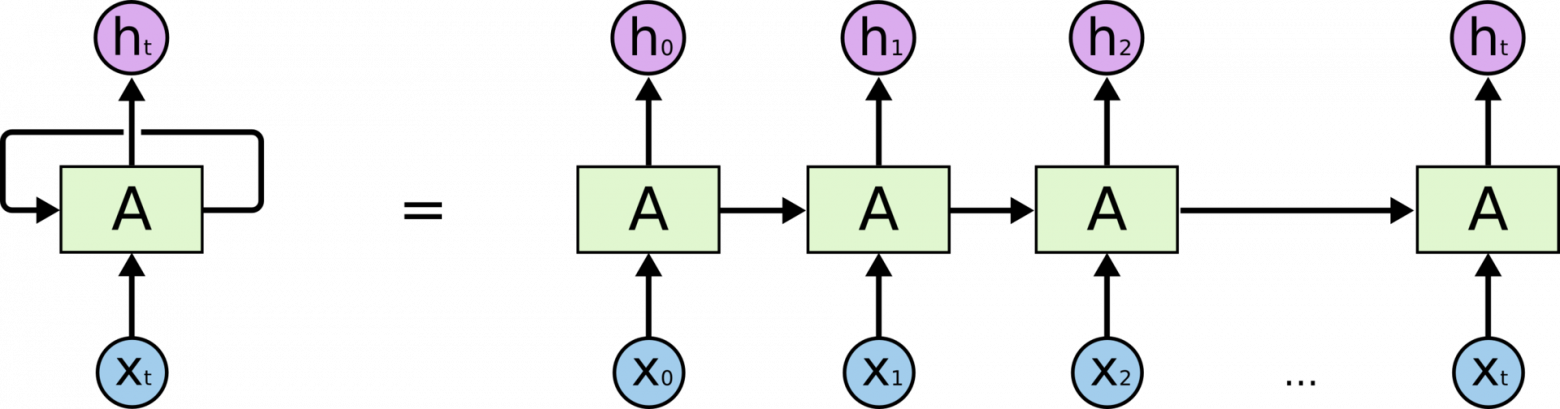

In [ ]:
# обязательно меняем num_classes на 4
class CharLM(nn.Module):
    def __init__(
        self, hidden_dim: int, vocab_size: int, num_classes: int = 4,
        aggregation_type: str = 'max'
        ):
        super().__init__()
        # храним матрицы эмбеддингов
        self.embedding = nn.Embedding(vocab_size, hidden_dim)
        # определим рнн модуль,batch_first =размерность =размер батча
        self.rnn = nn.RNN(hidden_dim, hidden_dim, batch_first=True)
        # и два линейных слоя, в конце выход = 4 классам

        self.linear = nn.Linear(hidden_dim, hidden_dim)
        self.projection = nn.Linear(hidden_dim, num_classes)

        self.non_lin = nn.Tanh()
        self.dropout = nn.Dropout(p=0.1)

        self.aggregation_type = aggregation_type

    def forward(self, input_batch) -> torch.Tensor:
      # считаем эмбеддинги, и у нас прибавляется размерность на вход было [batch_size, seq_len]
        embeddings = self.embedding(input_batch)  # [batch_size, seq_len, hidden_dim]
        output, _ = self.rnn(embeddings)  # [batch_size, seq_len, hidden_dim]
#  сравниваем два подхода агрегации - макспулинг и среднее
        if self.aggregation_type == 'max':
            output = output.max(dim=1)[0] # на возврат идет [batch_size, hidden_dim]
        elif self.aggregation_type == 'mean':
            output = output.mean(dim=1) #[batch_size, hidden_dim]
        else:
            raise ValueError("Invalid aggregation_type")
# весь путь: нелинейное - линейное -дропаут - нелинейное - проекция
        output = self.dropout(self.linear(self.non_lin(output)))  # [batch_size, hidden_dim]
        prediction = self.projection(self.non_lin(output))  # [batch_size, num_classes]

        return prediction

In [ ]:
model = CharLM(hidden_dim=256, vocab_size=len(vocab)).to(device)
# игнорируем индексы пат токена тк нет смысла считать лосс по нему
criterion = nn.CrossEntropyLoss(ignore_index=word2ind['<pad>'])

optimizer = torch.optim.Adam(model.parameters())

In [ ]:
# колво шагов для валидации
num_epoch = 5
# Частота валидации: модель проверяется после прохождения половины обучающих данных.
eval_steps = len(train_dataloader) // 2
losses_type = {}
acc_type = {}

for aggregation_type in ['max', 'mean']:
    print(f"Starting training for {aggregation_type}")
    losses = []
    acc = []
    best_acc=None
    quality_counter=0
    #  считает количество эпох, на которых точность не улучшается
    break_marker=0

# надо заново инициализировать модель
    model = CharLM(hidden_dim=256, vocab_size=len(vocab), aggregation_type=aggregation_type).to(device)
    criterion = nn.CrossEntropyLoss(ignore_index=word2ind['<pad>'])
    optimizer = torch.optim.Adam(model.parameters())

    for epoch in range(num_epoch):
        epoch_losses = []
        # переводит модель в режим обучения (активирует dropout и batch norm).
        model.train()
        for i, batch in enumerate(tqdm(train_dataloader, desc=f'Training epoch {epoch}:')):
          # обнуляем градиент
            optimizer.zero_grad()
            # считем логиты (форвард)
            logits = model(batch['input_ids'])
            # считаем лосс
            loss = criterion(logits, batch['label'])
            # делаем беквард
            loss.backward()
            # шаг градиентного спуска (обновление весов)
            optimizer.step()
            epoch_losses.append(loss.item())
 # валидация
            if i % eval_steps == 0:
              # евал отключает дропаут -> переводим модель в режим валидации
                model.eval()
                accuracy=evaluate(model)
                # возвращаем режим обучения
                model.train()
                acc.append(accuracy)

                if best_acc is None:
                    best_acc= accuracy
                elif best_acc<accuracy:
                    best_acc= accuracy
                    quality_counter=0
                    torch.save(model.state_dict(),f'model_{aggregation_type}_state_dict_epoch_{epoch+1}_{best_acc*100:.2f}.pt')
                    print(f'Сохранили модель на эпохе {epoch+1} с accuracy {accuracy* 100:.2f}')
                else: # early stopping
                    quality_counter+=1
                    if quality_counter>4:
                        break_marker = True
                        break
                        # Если точность улучшилась, сохраняем модель и сбрасываем quality_counter, если нет, то после 4 стабильных эпох останавливаем


        losses.append(sum(epoch_losses) / len(epoch_losses))
        print('Train loss:', losses [-1])
        if break_marker:
            break

    losses_type[aggregation_type] = losses
    acc_type[aggregation_type] = acc

Starting training for max


Training epoch 0::   0%|          | 0/3750 [00:00<?, ?it/s]

Сохранили модель на эпохе 1 с accuracy 84.38
Train loss: 0.4077558755675952


Training epoch 1::   0%|          | 0/3750 [00:00<?, ?it/s]

Сохранили модель на эпохе 2 с accuracy 89.66
Train loss: 0.28346431478212275


Training epoch 2::   0%|          | 0/3750 [00:00<?, ?it/s]

Сохранили модель на эпохе 3 с accuracy 89.92
Train loss: 0.2485916424319148


Training epoch 3::   0%|          | 0/3750 [00:00<?, ?it/s]

Сохранили модель на эпохе 4 с accuracy 89.94
Train loss: 0.22651169370164473


Training epoch 4::   0%|          | 0/3750 [00:00<?, ?it/s]

Сохранили модель на эпохе 5 с accuracy 90.02
Train loss: 0.21004278051753839
Starting training for mean


Training epoch 0::   0%|          | 0/3750 [00:00<?, ?it/s]

Сохранили модель на эпохе 1 с accuracy 87.00
Train loss: 0.43368729448864857


Training epoch 1::   0%|          | 0/3750 [00:00<?, ?it/s]

Сохранили модель на эпохе 2 с accuracy 88.18
Сохранили модель на эпохе 2 с accuracy 89.60
Train loss: 0.2585583852633834


Training epoch 2::   0%|          | 0/3750 [00:00<?, ?it/s]

Сохранили модель на эпохе 3 с accuracy 90.02
Train loss: 0.21354066815103093


Training epoch 3::   0%|          | 0/3750 [00:00<?, ?it/s]

Сохранили модель на эпохе 4 с accuracy 90.18
Train loss: 0.18324638773103555


Training epoch 4::   0%|          | 0/3750 [00:00<?, ?it/s]

Сохранили модель на эпохе 5 с accuracy 90.56
Train loss: 0.1611372490624587


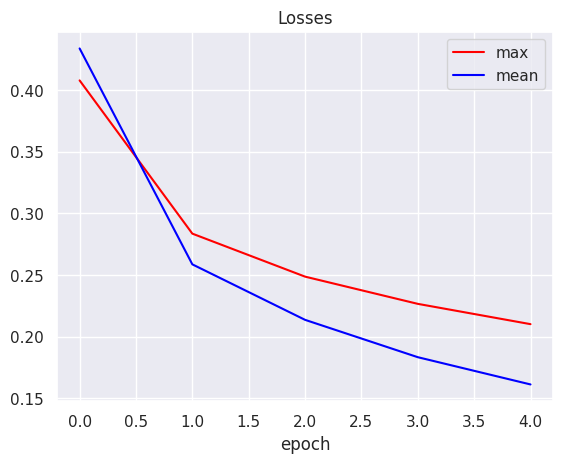

In [ ]:
for (name, values), color in zip(losses_type.items(), ['red', 'blue']):
    plt.plot(np.arange(len(losses_type[name])), losses_type[name], color=color, label=name)

plt.title('Losses')
plt.xlabel("epoch")
plt.legend()
plt.show()

Лучшая accuracy для подхода max: 90.02
Лучшая accuracy для подхода mean: 90.56


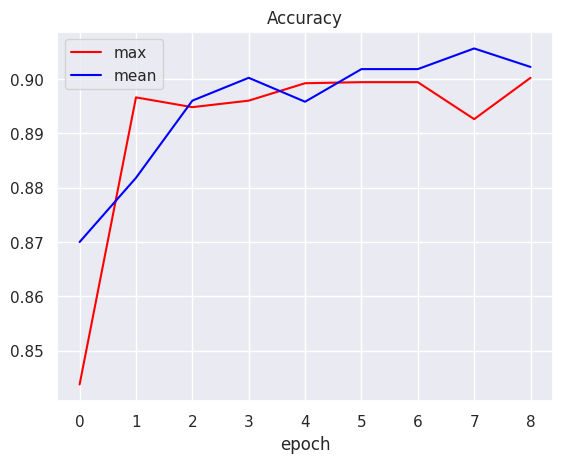

In [ ]:
for (name, values), color in zip(losses_type.items(), ['red', 'blue']):
    plt.plot(np.arange(len(acc_type[name][1:])), acc_type[name][1:], color=color, label=name)
    print(f"Лучшая accuracy для подхода {name}: {(max(acc_type[name]) * 100):.2f}")

plt.title('Accuracy')
plt.xlabel("epoch")
plt.legend()
plt.show()

подгрузим нашу модель - с агрегацией mean

In [ ]:
model1 = CharLM(hidden_dim=256, vocab_size=len(vocab), aggregation_type='mean').to(device)
model1.load_state_dict(torch.load('model_mean_state_dict_epoch_5_90.56.pt'))

<ipython-input-48-ec39fd3feebe>:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model1.load_state_dict(torch.load('model_mean_state_dict_epoch_5_90.56.pt'))


<All keys matched successfully>

In [ ]:
model1.eval()
print('Accuracy:',evaluate(model1)*100)

Accuracy: 90.55999517440796


## **Проведем некоторые эксперименты, чтобы попробовать повысить accuracy нашей модели**

### **LSTM - модель (Long short-term memory)**

Устройство классической LSTM-модели ([источник](https://habr.com/ru/companies/wunderfund/articles/331310//)) :

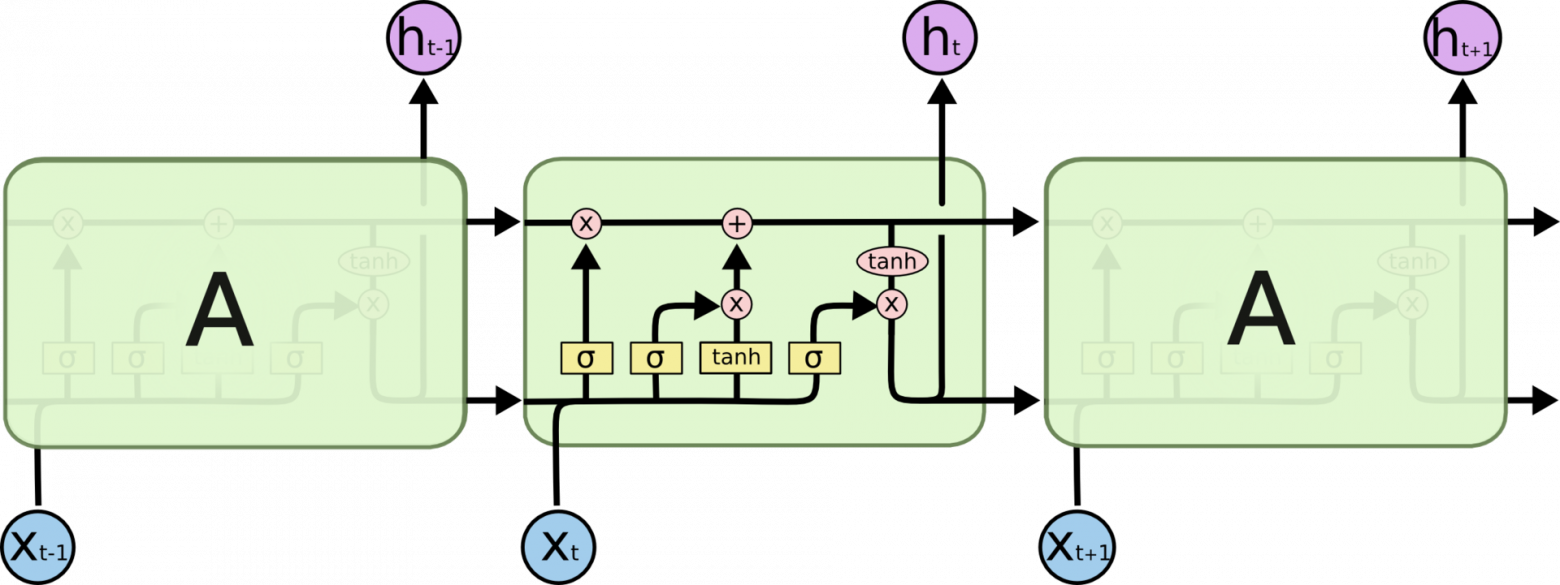

Где используются обозначения:

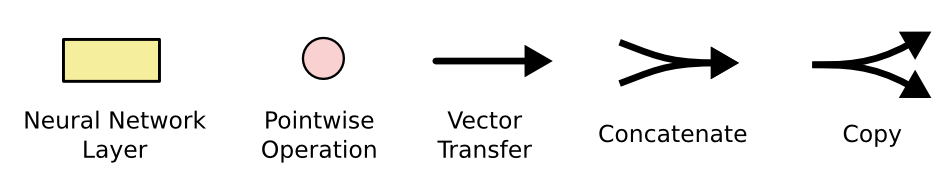

In [ ]:
class LSTM(nn.Module):
    def __init__(self, hidden_dim: int, vocab_size: int, num_classes: int = 4, aggregation_type: str = 'max'):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, hidden_dim)

        # Используем LSTM вместо RNN
        self.lstm = nn.LSTM(hidden_dim, hidden_dim, batch_first=True)

        self.linear = nn.Linear(hidden_dim, hidden_dim)
        self.projection = nn.Linear(hidden_dim, num_classes)

        self.non_lin = nn.Tanh()
        self.dropout = nn.Dropout(p=0.1)

        self.aggregation_type = aggregation_type

    def forward(self, input_batch) -> torch.Tensor:
        embeddings = self.embedding(input_batch)  # [batch_size, seq_len, hidden_dim]
        output, (hidden, cell) = self.lstm(embeddings)  # LSTM возвращает (output, (hidden_state, cell_state))

        # Агрегация по скрытым состояниям
        if self.aggregation_type == 'max':
            output = output.max(dim=1)[0]  # [batch_size, hidden_dim]
        elif self.aggregation_type == 'mean':
            output = output.mean(dim=1)  # [batch_size, hidden_dim]
        else:
            raise ValueError("Invalid aggregation_type")

        output = self.dropout(self.linear(self.non_lin(output)))  # [batch_size, hidden_dim]
        prediction = self.projection(self.non_lin(output))  # [batch_size, num_classes]

        return prediction

In [ ]:
model = LSTM(hidden_dim=256, vocab_size=len(vocab)).to(device)
# игнорируем индексы пат токена тк нет смысла считать лосс по нему
criterion = nn.CrossEntropyLoss(ignore_index=word2ind['<pad>'])

optimizer = torch.optim.Adam(model.parameters())

In [ ]:
num_epoch = 5
# колво шагов для валидации
eval_steps = len(train_dataloader) // 2


losses_type = {}
acc_type = {}

for aggregation_type in ['max', 'mean']:
    print(f"Starting training for {aggregation_type}")
    losses = []
    acc = []
    best_acc=None
    quality_counter=0
    #  считает количество эпох, на которых точность не улучшается
    break_marker=0
# надо заново инициализировать модель
    model = LSTM(hidden_dim=256, vocab_size=len(vocab), aggregation_type=aggregation_type).to(device)
    criterion = nn.CrossEntropyLoss(ignore_index=word2ind['<pad>'])
    optimizer = torch.optim.Adam(model.parameters())

    for epoch in range(num_epoch):
        epoch_losses = []
        # переводит модель в режим обучения (активирует dropout и batch norm).
        model.train()
        for i, batch in enumerate(tqdm(train_dataloader, desc=f'Training epoch {epoch}:')):
          # обнуляем градиент
            optimizer.zero_grad()
            # считем логиты (форвард)
            logits = model(batch['input_ids'])
            # считаем лосс
            loss = criterion(logits, batch['label'])
            # делаем беквард
            loss.backward()
            # шаг градиентного спуска (обновление весов)
            optimizer.step()
            epoch_losses.append(loss.item())
 # валидация
            if i % eval_steps == 0:
              # евал отключает дропаут -> переводим модель в режим валидации
                model.eval()
                accuracy=evaluate(model)
                # возвращаем режим обучения
                model.train()
                acc.append(accuracy)

                if best_acc is None:
                    best_acc= accuracy
                elif best_acc<accuracy:
                    best_acc= accuracy
                    quality_counter=0
                    torch.save(model.state_dict(),f'model_{aggregation_type}_state_dict_epoch_{epoch+1}_{best_acc*100:.2f}.pt')
                    print(f'Сохранили модель на эпохе {epoch+1} с accuracy {accuracy* 100:.2f}')
                else: # early stopping
                    quality_counter+=1
                    if quality_counter>4:
                        break_marker = True
                        break
                        # Если точность улучшилась, сохраняем модель и сбрасываем quality_counter, если нет, то после 4 стабильных эпох останавливаем


        losses.append(sum(epoch_losses) / len(epoch_losses))
        print('Train loss:', losses [-1])
        if break_marker:
             break

    losses_type[aggregation_type] = losses
    acc_type[aggregation_type] = acc

Starting training for max


Training epoch 0::   0%|          | 0/3750 [00:00<?, ?it/s]

Сохранили модель на эпохе 1 с accuracy 89.44
Train loss: 0.3488838730533918


Training epoch 1::   0%|          | 0/3750 [00:00<?, ?it/s]

Сохранили модель на эпохе 2 с accuracy 90.68
Train loss: 0.20709727072715758


Training epoch 2::   0%|          | 0/3750 [00:00<?, ?it/s]

Сохранили модель на эпохе 3 с accuracy 90.88
Train loss: 0.14959971095062793


Training epoch 3::   0%|          | 0/3750 [00:00<?, ?it/s]

Train loss: 0.10385984467038265


Training epoch 4::   0%|          | 0/3750 [00:00<?, ?it/s]

Train loss: 0.06078912808651925
Starting training for mean


Training epoch 0::   0%|          | 0/3750 [00:00<?, ?it/s]

Сохранили модель на эпохе 1 с accuracy 89.50
Train loss: 0.3630797936722636


Training epoch 1::   0%|          | 0/3750 [00:00<?, ?it/s]

Сохранили модель на эпохе 2 с accuracy 91.26
Train loss: 0.20544905921990672


Training epoch 2::   0%|          | 0/3750 [00:00<?, ?it/s]

Сохранили модель на эпохе 3 с accuracy 91.58
Train loss: 0.13909230752773583


Training epoch 3::   0%|          | 0/3750 [00:00<?, ?it/s]

Train loss: 0.08593931486095922


Training epoch 4::   0%|          | 0/3750 [00:00<?, ?it/s]

Train loss: 0.045526539495170514


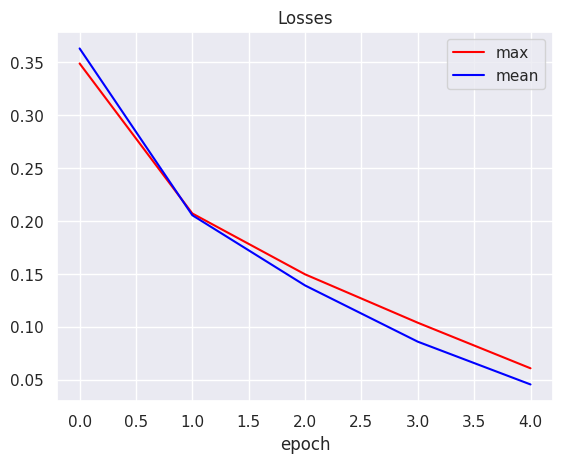

In [ ]:
for (name, values), color in zip(losses_type.items(), ['red', 'blue']):
    plt.plot(np.arange(len(losses_type[name])), losses_type[name], color=color, label=name)

plt.title('Losses')
plt.xlabel("epoch")
plt.legend()
plt.show()

Лучшая accuracy для подхода max: 90.88
Лучшая accuracy для подхода mean: 91.58


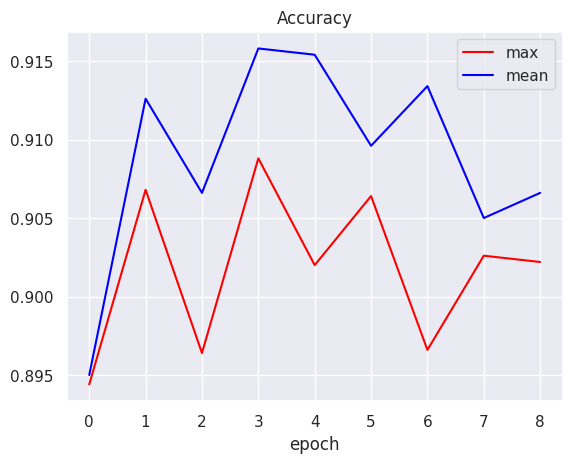

In [ ]:
for (name, values), color in zip(losses_type.items(), ['red', 'blue']):
    plt.plot(np.arange(len(acc_type[name][1:])), acc_type[name][1:], color=color, label=name)
    print(f"Лучшая accuracy для подхода {name}: {(max(acc_type[name]) * 100):.2f}")

plt.title('Accuracy')
plt.xlabel("epoch")
plt.legend()
plt.show()

In [ ]:
model2 = LSTM(hidden_dim=256, vocab_size=len(vocab), aggregation_type='mean').to(device)
model2.load_state_dict(torch.load('model_mean_state_dict_epoch_3_91.58.pt'))

<ipython-input-66-46b9027b26f8>:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model2.load_state_dict(torch.load('model_mean_state_dict_epoch_3_91.58.pt'))


<All keys matched successfully>

In [ ]:
model2.eval()
print('Accuracy:',evaluate(model2)*100)

Accuracy: 91.57999753952026


### **GRU (Gated recurrent units) -- необходимая метрика достигнута**




Архитектура стандартной модели GRU ([источник](https://habr.com/ru/companies/wunderfund/articles/331310//)) :

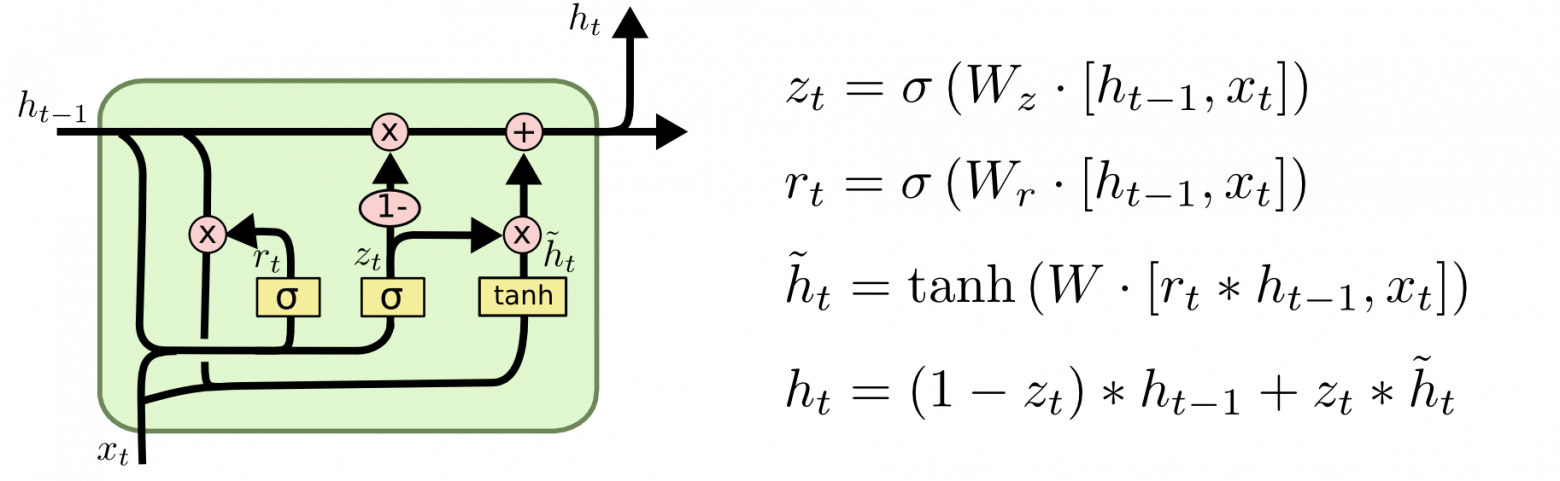

Фактически, GRU является упрощенной версией LSTM

In [ ]:
class GRU(nn.Module):
    def __init__(
        self, hidden_dim: int, vocab_size: int, num_classes: int = 4,
        aggregation_type: str = 'max'
        ):
        super().__init__()
        # храним матрицы эмбеддингов
        self.embedding = nn.Embedding(vocab_size, hidden_dim)
        # определяем GRU-модуль
        self.rnn = nn.GRU(hidden_dim, hidden_dim, batch_first=True)
        # и два линейных слоя, в конце выход = 4 классам

        self.linear = nn.Linear(hidden_dim, hidden_dim)
        self.projection = nn.Linear(hidden_dim, num_classes)

        self.non_lin = nn.Tanh()
        self.dropout = nn.Dropout(p=0.1)

        self.aggregation_type = aggregation_type

    def forward(self, input_batch) -> torch.Tensor:
      # считаем эмбеддинги, и у нас прибавляется размерность на вход было [batch_size, seq_len]
        embeddings = self.embedding(input_batch)  # [batch_size, seq_len, hidden_dim]
        output, _ = self.rnn(embeddings)  # [batch_size, seq_len, hidden_dim]
#  сравниваем два подхода агрегации - макспулинг и среднее
        if self.aggregation_type == 'max':
            output = output.max(dim=1)[0] # на возврат идет [batch_size, hidden_dim]
        elif self.aggregation_type == 'mean':
            output = output.mean(dim=1) #[batch_size, hidden_dim]
        else:
            raise ValueError("Invalid aggregation_type")
# весь путь: нелинейное - линейное -дропаут - нелинейное - проекция
        output = self.dropout(self.linear(self.non_lin(output)))  # [batch_size, hidden_dim]
        prediction = self.projection(self.non_lin(output))  # [batch_size, num_classes]

        return prediction

In [ ]:
model = GRU(hidden_dim=256, vocab_size=len(vocab)).to(device)
# игнорируем индексы пат токена тк нет смысла считать лосс по нему
criterion = nn.CrossEntropyLoss(ignore_index=word2ind['<pad>'])

optimizer = torch.optim.Adam(model.parameters())

In [ ]:
# колво шагов для валидации
num_epoch = 5
# Частота валидации: модель проверяется после прохождения половины обучающих данных.
eval_steps = len(train_dataloader) // 2
losses_type = {}
acc_type = {}

for aggregation_type in ['max', 'mean']:
    print(f"Starting training for {aggregation_type}")
    losses = []
    acc = []
    best_acc=None
    quality_counter=0
    #  считает количество эпох, на которых точность не улучшается
    break_marker=0

# надо заново инициализировать модель
    model = GRU(hidden_dim=256, vocab_size=len(vocab), aggregation_type=aggregation_type).to(device)
    criterion = nn.CrossEntropyLoss(ignore_index=word2ind['<pad>'])
    optimizer = torch.optim.Adam(model.parameters())

    for epoch in range(num_epoch):
        epoch_losses = []
        # переводит модель в режим обучения (активирует dropout и batch norm).
        model.train()
        for i, batch in enumerate(tqdm(train_dataloader, desc=f'Training epoch {epoch}:')):
          # обнуляем градиент
            optimizer.zero_grad()
            # считем логиты (форвард)
            logits = model(batch['input_ids'])
            # считаем лосс
            loss = criterion(logits, batch['label'])
            # делаем беквард
            loss.backward()
            # шаг градиентного спуска (обновление весов)
            optimizer.step()


# валидация
            epoch_losses.append(loss.item())
            if i % eval_steps == 0:
              # евал отключает дропаут -> переводим модель в режим валидации
                model.eval()
                accuracy=evaluate(model)
                # возвращаем режим обучения
                model.train()
                acc.append(accuracy)

                if best_acc is None:
                    best_acc= accuracy
                elif best_acc<accuracy:
                    best_acc= accuracy
                    quality_counter=0
                    torch.save(model.state_dict(),f'model_{aggregation_type}_state_dict_epoch_{epoch+1}_{best_acc*100:.2f}.pt')
                    print(f'Сохранили модель на эпохе {epoch+1} с accuracy {accuracy* 100:.2f}')
                else: # early stopping
                    quality_counter+=1
                    if quality_counter>4:
                        break_marker = True
                        break
                        # Если точность улучшилась, сохраняем модель и сбрасываем quality_counter, если нет, то после 4 стабильных эпох останавливаем


        losses.append(sum(epoch_losses) / len(epoch_losses))
        print('Train loss:', losses [-1])
        if break_marker:
            break

    losses_type[aggregation_type] = losses
    acc_type[aggregation_type] = acc

Starting training for max


Training epoch 0::   0%|          | 0/3750 [00:00<?, ?it/s]

Сохранили модель на эпохе 1 с accuracy 89.58
Train loss: 0.352264818434914


Training epoch 1::   0%|          | 0/3750 [00:00<?, ?it/s]

Сохранили модель на эпохе 2 с accuracy 91.42
Train loss: 0.2175475068166852


Training epoch 2::   0%|          | 0/3750 [00:00<?, ?it/s]

Сохранили модель на эпохе 3 с accuracy 91.46
Train loss: 0.1672967700968186


Training epoch 3::   0%|          | 0/3750 [00:00<?, ?it/s]

Сохранили модель на эпохе 4 с accuracy 91.92
Train loss: 0.12486638920741777


Training epoch 4::   0%|          | 0/3750 [00:00<?, ?it/s]

Train loss: 0.09338042819524804
Starting training for mean


Training epoch 0::   0%|          | 0/3750 [00:00<?, ?it/s]

Сохранили модель на эпохе 1 с accuracy 88.88
Train loss: 0.3645408927122752


Training epoch 1::   0%|          | 0/3750 [00:00<?, ?it/s]

Сохранили модель на эпохе 2 с accuracy 90.72
Сохранили модель на эпохе 2 с accuracy 90.86
Train loss: 0.21100767612208923


Training epoch 2::   0%|          | 0/3750 [00:00<?, ?it/s]

Сохранили модель на эпохе 3 с accuracy 90.94
Train loss: 0.1443437512392799


Training epoch 3::   0%|          | 0/3750 [00:00<?, ?it/s]

Train loss: 0.09548234867307667


Training epoch 4::   0%|          | 0/3750 [00:00<?, ?it/s]

Сохранили модель на эпохе 5 с accuracy 91.06
Сохранили модель на эпохе 5 с accuracy 91.30
Train loss: 0.06910194186017228


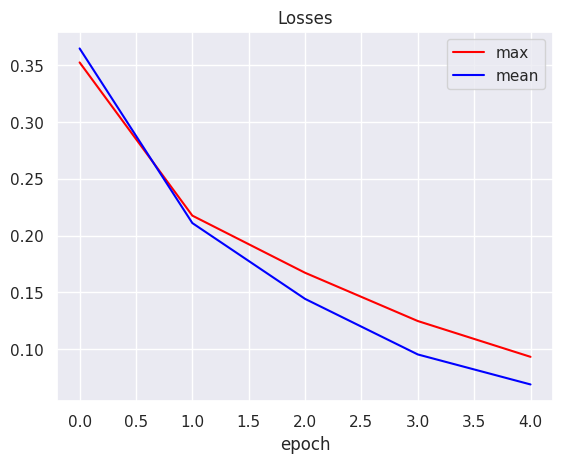

In [ ]:
for (name, values), color in zip(losses_type.items(), ['red', 'blue']):
    plt.plot(np.arange(len(losses_type[name])), losses_type[name], color=color, label=name)

plt.title('Losses')
plt.xlabel("epoch")
plt.legend()
plt.show()

Лучшая accuracy для подхода max: 91.92
Лучшая accuracy для подхода mean: 91.30


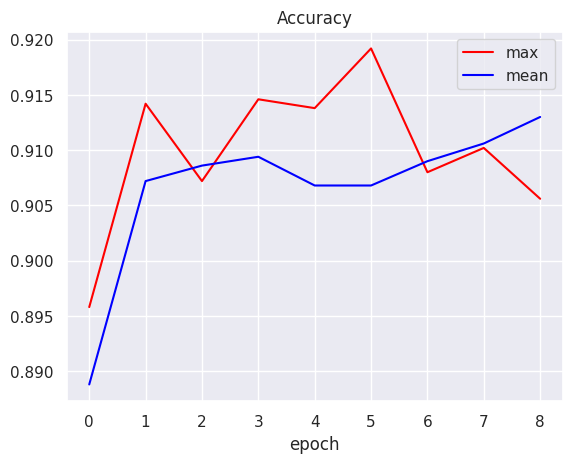

In [ ]:
for (name, values), color in zip(losses_type.items(), ['red', 'blue']):
    plt.plot(np.arange(len(acc_type[name][1:])), acc_type[name][1:], color=color, label=name)
    print(f"Лучшая accuracy для подхода {name}: {(max(acc_type[name]) * 100):.2f}")

plt.title('Accuracy')
plt.xlabel("epoch")
plt.legend()
plt.show()

In [ ]:
model4 = GRU(hidden_dim=256, vocab_size=len(vocab), aggregation_type='max').to(device)
model4.load_state_dict(torch.load('model_max_state_dict_epoch_4_91.92.pt'))

<ipython-input-38-2e91a4947e3f>:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model4.load_state_dict(torch.load('model_max_state_dict_epoch_4_91.92.pt'))


<All keys matched successfully>

In [ ]:
model4.eval()

GRU(
  (embedding): Embedding(11842, 256)
  (rnn): GRU(256, 256, batch_first=True)
  (linear): Linear(in_features=256, out_features=256, bias=True)
  (projection): Linear(in_features=256, out_features=4, bias=True)
  (non_lin): Tanh()
  (dropout): Dropout(p=0.1, inplace=False)
)

In [ ]:
print('Accuracy:',evaluate(model4)*100)

Accuracy: 91.92000031471252


Пробили необходимую метрику - >= 0.915

### **GRU - hiddem_dim=512 - the BEST model**

Попробуем увеличить количество нейронов в скрытом слое до 512.

In [ ]:
class GRU(nn.Module):
    def __init__(
        self, hidden_dim: int, vocab_size: int, num_classes: int = 4,
        aggregation_type: str = 'max'
        ):
        super().__init__()
        # храним матрицы эмбеддингов
        self.embedding = nn.Embedding(vocab_size, hidden_dim)
        # определяем GRU-модуль
        self.rnn = nn.GRU(hidden_dim, hidden_dim, batch_first=True)
        # и два линейных слоя, в конце выход = 4 классам

        self.linear = nn.Linear(hidden_dim, hidden_dim)
        self.projection = nn.Linear(hidden_dim, num_classes)

        self.non_lin = nn.Tanh()
        self.dropout = nn.Dropout(p=0.1)

        self.aggregation_type = aggregation_type

    def forward(self, input_batch) -> torch.Tensor:
      # считаем эмбеддинги, и у нас прибавляется размерность на вход было [batch_size, seq_len]
        embeddings = self.embedding(input_batch)  # [batch_size, seq_len, hidden_dim]
        output, _ = self.rnn(embeddings)  # [batch_size, seq_len, hidden_dim]
#  сравниваем два подхода агрегации - макспулинг и среднее
        if self.aggregation_type == 'max':
            output = output.max(dim=1)[0] # на возврат идет [batch_size, hidden_dim]
        elif self.aggregation_type == 'mean':
            output = output.mean(dim=1) #[batch_size, hidden_dim]
        else:
            raise ValueError("Invalid aggregation_type")
# весь путь: нелинейное - линейное -дропаут - нелинейное - проекция
        output = self.dropout(self.linear(self.non_lin(output)))  # [batch_size, hidden_dim]
        prediction = self.projection(self.non_lin(output))  # [batch_size, num_classes]

        return prediction


In [ ]:
model = GRU(hidden_dim=512, vocab_size=len(vocab)).to(device)
# игнорируем индексы пат токена тк нет смысла считать лосс по нему
criterion = nn.CrossEntropyLoss(ignore_index=word2ind['<pad>'])

optimizer = torch.optim.Adam(model.parameters())

In [ ]:
# колво шагов для валидации
num_epoch = 5
# Частота валидации: модель проверяется после прохождения половины обучающих данных.
eval_steps = len(train_dataloader) // 2
losses_type = {}
acc_type = {}

for aggregation_type in ['max', 'mean']:
    print(f"Starting training for {aggregation_type}")
    losses = []
    acc = []
    best_acc=None
    quality_counter=0
    #  считает количество эпох, на которых точность не улучшается
    break_marker=0

# надо заново инициализировать модель
    model = GRU(hidden_dim=512, vocab_size=len(vocab), aggregation_type=aggregation_type).to(device)
    criterion = nn.CrossEntropyLoss(ignore_index=word2ind['<pad>'])
    optimizer = torch.optim.Adam(model.parameters())

    for epoch in range(num_epoch):
        epoch_losses = []
        # переводит модель в режим обучения (активирует dropout и batch norm).
        model.train()
        for i, batch in enumerate(tqdm(train_dataloader, desc=f'Training epoch {epoch}:')):
          # обнуляем градиент
            optimizer.zero_grad()
            # считем логиты (форвард)
            logits = model(batch['input_ids'])
            # считаем лосс
            loss = criterion(logits, batch['label'])
            # делаем беквард
            loss.backward()
            # шаг градиентного спуска (обновление весов)
            optimizer.step()


# валидация
            epoch_losses.append(loss.item())
            if i % eval_steps == 0:
              # евал отключает дропаут -> переводим модель в режим валидации
                model.eval()
                accuracy=evaluate(model)
                # возвращаем режим обучения
                model.train()
                acc.append(accuracy)

                if best_acc is None:
                    best_acc= accuracy
                elif best_acc<accuracy:
                    best_acc= accuracy
                    quality_counter=0
                    torch.save(model.state_dict(),f'model_{aggregation_type}_state_dict_epoch_{epoch+1}_{best_acc*100:.2f}.pt')
                    print(f'Сохранили модель на эпохе {epoch+1} с accuracy {accuracy* 100:.2f}')
                else: # early stopping
                    quality_counter+=1
                    if quality_counter>4:
                        break_marker = True
                        break
                        # Если точность улучшилась, сохраняем модель и сбрасываем quality_counter, если нет, то после 4 стабильных эпох останавливаем


        losses.append(sum(epoch_losses) / len(epoch_losses))
        print('Train loss:', losses [-1])
        if break_marker:
            break

    losses_type[aggregation_type] = losses
    acc_type[aggregation_type] = acc

Starting training for max


Training epoch 0::   0%|          | 0/3750 [00:00<?, ?it/s]

Сохранили модель на эпохе 1 с accuracy 89.08
Train loss: 0.3337242333009839


Training epoch 1::   0%|          | 0/3750 [00:00<?, ?it/s]

Сохранили модель на эпохе 2 с accuracy 91.28
Train loss: 0.212200664147983


Training epoch 2::   0%|          | 0/3750 [00:00<?, ?it/s]

Сохранили модель на эпохе 3 с accuracy 92.02
Train loss: 0.16177140758323172


Training epoch 3::   0%|          | 0/3750 [00:00<?, ?it/s]

Train loss: 0.1245042635390535


Training epoch 4::   0%|          | 0/3750 [00:00<?, ?it/s]

Train loss: 0.08376129805488311
Starting training for mean


Training epoch 0::   0%|          | 0/3750 [00:00<?, ?it/s]

Сохранили модель на эпохе 1 с accuracy 89.34
Train loss: 0.34433178592969976


Training epoch 1::   0%|          | 0/3750 [00:00<?, ?it/s]

Сохранили модель на эпохе 2 с accuracy 90.84
Train loss: 0.1982785901196301


Training epoch 2::   0%|          | 0/3750 [00:00<?, ?it/s]

Сохранили модель на эпохе 3 с accuracy 90.98
Train loss: 0.13639419293490548


Training epoch 3::   0%|          | 0/3750 [00:00<?, ?it/s]

Сохранили модель на эпохе 4 с accuracy 91.24
Train loss: 0.09892447214437028


Training epoch 4::   0%|          | 0/3750 [00:00<?, ?it/s]

Train loss: 0.07778700608043


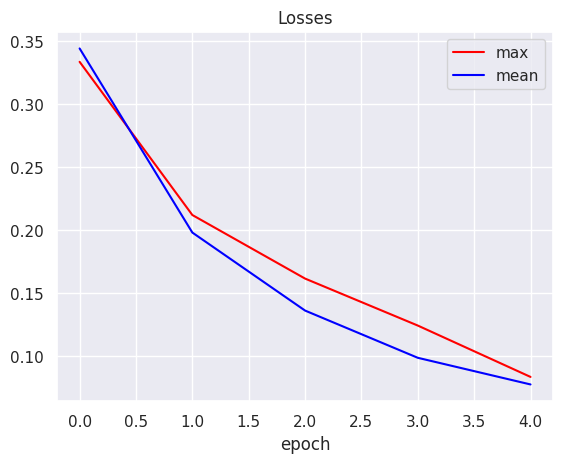

In [ ]:
for (name, values), color in zip(losses_type.items(), ['red', 'blue']):
    plt.plot(np.arange(len(losses_type[name])), losses_type[name], color=color, label=name)

plt.title('Losses')
plt.xlabel("epoch")
plt.legend()
plt.show()

Лучшая accuracy для подхода max: 92.02
Лучшая accuracy для подхода mean: 91.24


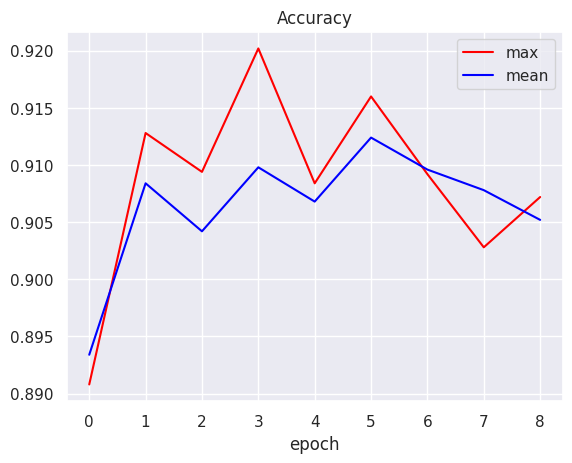

In [ ]:
for (name, values), color in zip(losses_type.items(), ['red', 'blue']):
    plt.plot(np.arange(len(acc_type[name][1:])), acc_type[name][1:], color=color, label=name)
    print(f"Лучшая accuracy для подхода {name}: {(max(acc_type[name]) * 100):.2f}")

plt.title('Accuracy')
plt.xlabel("epoch")
plt.legend()
plt.show()

In [ ]:
model5 = GRU(hidden_dim=512, vocab_size=len(vocab), aggregation_type='max').to(device)
model5.load_state_dict(torch.load('model_max_state_dict_epoch_3_92.02.pt'))

<ipython-input-16-100e66e5b522>:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model5.load_state_dict(torch.load('model_max_state_dict_epoch_3_92.02.pt'))


<All keys matched successfully>

### **Лучшая метрика**

In [ ]:
model5.eval()
print('Accuracy:',evaluate(model5)*100)

Accuracy: 92.0199990272522


Отлично, можно заметить, что модель  GRU в целом неплохо справляется с задачей.

### **GRU - dropout=0.2**

Также заметим, что я вернула количество скрытых нейронов к базовому состоянию - до 256, чтобы сравнить влияние изменения величины dropout'а с изменением hidden_dim на метрику.

In [ ]:
class GRU(nn.Module):
    def __init__(
        self, hidden_dim: int, vocab_size: int, num_classes: int = 4,
        aggregation_type: str = 'max'
        ):
        super().__init__()
        # храним матрицы эмбеддингов
        self.embedding = nn.Embedding(vocab_size, hidden_dim)
        # определяем GRU-модуль
        self.rnn = nn.GRU(hidden_dim, hidden_dim, batch_first=True)
        # и два линейных слоя, в конце выход = 4 классам

        self.linear = nn.Linear(hidden_dim, hidden_dim)
        self.projection = nn.Linear(hidden_dim, num_classes)

        self.non_lin = nn.Tanh()
        self.dropout = nn.Dropout(p=0.2)

        self.aggregation_type = aggregation_type

    def forward(self, input_batch) -> torch.Tensor:
      # считаем эмбеддинги, и у нас прибавляется размерность на вход было [batch_size, seq_len]
        embeddings = self.embedding(input_batch)  # [batch_size, seq_len, hidden_dim]
        output, _ = self.rnn(embeddings)  # [batch_size, seq_len, hidden_dim]
#  сравниваем два подхода агрегации - макспулинг и среднее
        if self.aggregation_type == 'max':
            output = output.max(dim=1)[0] # на возврат идет [batch_size, hidden_dim]
        elif self.aggregation_type == 'mean':
            output = output.mean(dim=1) #[batch_size, hidden_dim]
        else:
            raise ValueError("Invalid aggregation_type")
# весь путь: нелинейное - линейное -дропаут - нелинейное - проекция
        output = self.dropout(self.linear(self.non_lin(output)))  # [batch_size, hidden_dim]
        prediction = self.projection(self.non_lin(output))  # [batch_size, num_classes]

        return prediction

In [ ]:
# колво шагов для валидации
num_epoch = 5
# Частота валидации: модель проверяется после прохождения половины обучающих данных.
eval_steps = len(train_dataloader) // 2
losses_type = {}
acc_type = {}

for aggregation_type in ['max', 'mean']:
    print(f"Starting training for {aggregation_type}")
    losses = []
    acc = []
    best_acc=None
    quality_counter=0
    #  считает количество эпох, на которых точность не улучшается
    break_marker=0

# надо заново инициализировать модель
    model = GRU(hidden_dim=256, vocab_size=len(vocab), aggregation_type=aggregation_type).to(device)
    criterion = nn.CrossEntropyLoss(ignore_index=word2ind['<pad>'])
    optimizer = torch.optim.Adam(model.parameters())

    for epoch in range(num_epoch):
        epoch_losses = []
        # переводит модель в режим обучения (активирует dropout и batch norm).
        model.train()
        for i, batch in enumerate(tqdm(train_dataloader, desc=f'Training epoch {epoch}:')):
          # обнуляем градиент
            optimizer.zero_grad()
            # считем логиты (форвард)
            logits = model(batch['input_ids'])
            # считаем лосс
            loss = criterion(logits, batch['label'])
            # делаем беквард
            loss.backward()
            # шаг градиентного спуска (обновление весов)
            optimizer.step()


# валидация
            epoch_losses.append(loss.item())
            if i % eval_steps == 0:
              # евал отключает дропаут -> переводим модель в режим валидации
                model.eval()
                accuracy=evaluate(model)
                # возвращаем режим обучения
                model.train()
                acc.append(accuracy)

                if best_acc is None:
                    best_acc= accuracy
                elif best_acc<accuracy:
                    best_acc= accuracy
                    quality_counter=0
                    torch.save(model.state_dict(),f'model_{aggregation_type}_state_dict_epoch_{epoch+1}_{best_acc*100:.2f}.pt')
                    print(f'Сохранили модель на эпохе {epoch+1} с accuracy {accuracy* 100:.2f}')
                else: # early stopping
                    quality_counter+=1
                    if quality_counter>4:
                        break_marker = True
                        break
                        # Если точность улучшилась, сохраняем модель и сбрасываем quality_counter, если нет, то после 4 стабильных эпох останавливаем


        losses.append(sum(epoch_losses) / len(epoch_losses))
        print('Train loss:', losses [-1])
        if break_marker:
            break

    losses_type[aggregation_type] = losses
    acc_type[aggregation_type] = acc

Starting training for max


Training epoch 0::   0%|          | 0/3750 [00:00<?, ?it/s]

Сохранили модель на эпохе 1 с accuracy 89.12
Train loss: 0.3544486294870575


Training epoch 1::   0%|          | 0/3750 [00:00<?, ?it/s]

Сохранили модель на эпохе 2 с accuracy 90.82
Сохранили модель на эпохе 2 с accuracy 91.94
Train loss: 0.21771623124877612


Training epoch 2::   0%|          | 0/3750 [00:00<?, ?it/s]

Train loss: 0.16634795685758194


Training epoch 3::   0%|          | 0/3750 [00:00<?, ?it/s]

Train loss: 0.12498700225744397


Training epoch 4::   0%|          | 0/3750 [00:00<?, ?it/s]

Train loss: 0.09549739211797714
Starting training for mean


Training epoch 0::   0%|          | 0/3750 [00:00<?, ?it/s]

Сохранили модель на эпохе 1 с accuracy 89.06
Train loss: 0.3668319370875756


Training epoch 1::   0%|          | 0/3750 [00:00<?, ?it/s]

Сохранили модель на эпохе 2 с accuracy 89.18
Сохранили модель на эпохе 2 с accuracy 91.00
Train loss: 0.21195656319782138


Training epoch 2::   0%|          | 0/3750 [00:00<?, ?it/s]

Сохранили модель на эпохе 3 с accuracy 91.10
Train loss: 0.14680271686849494


Training epoch 3::   0%|          | 0/3750 [00:00<?, ?it/s]

Train loss: 0.09978428704490264


Training epoch 4::   0%|          | 0/3750 [00:00<?, ?it/s]

Сохранили модель на эпохе 5 с accuracy 91.66
Train loss: 0.06990669217458927


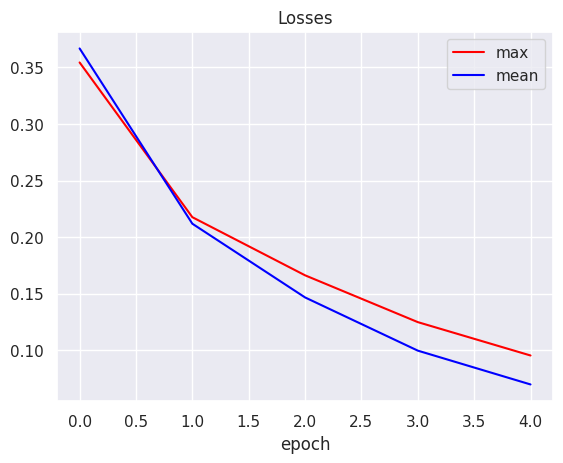

In [ ]:
for (name, values), color in zip(losses_type.items(), ['red', 'blue']):
    plt.plot(np.arange(len(losses_type[name])), losses_type[name], color=color, label=name)

plt.title('Losses')
plt.xlabel("epoch")
plt.legend()
plt.show()

Лучшая accuracy для подхода max: 91.94
Лучшая accuracy для подхода mean: 91.66


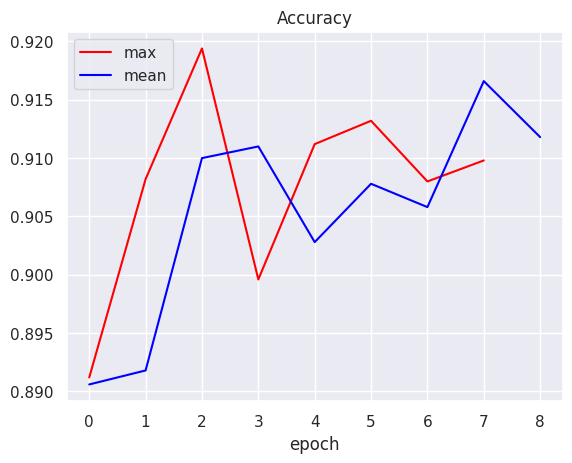

In [ ]:
for (name, values), color in zip(losses_type.items(), ['red', 'blue']):
    plt.plot(np.arange(len(acc_type[name][1:])), acc_type[name][1:], color=color, label=name)
    print(f"Лучшая accuracy для подхода {name}: {(max(acc_type[name]) * 100):.2f}")

plt.title('Accuracy')
plt.xlabel("epoch")
plt.legend()
plt.show()

In [ ]:
model6 = GRU(hidden_dim=256, vocab_size=len(vocab), aggregation_type='max').to(device)
model6.load_state_dict(torch.load('model_max_state_dict_epoch_2_91.94.pt'))

<ipython-input-24-b5c21388a502>:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model6.load_state_dict(torch.load('model_max_state_dict_epoch_2_91.94.pt'))


<All keys matched successfully>

In [ ]:
model6.eval()
print('Accuracy:',evaluate(model6)*100)

Accuracy: 91.93999767303467


### **GRU -  Linear output/input = hidden_dim//2**

In [ ]:
class GRU(nn.Module):
    def __init__(
        self, hidden_dim: int, vocab_size: int, num_classes: int = 4,
        aggregation_type: str = 'max'
        ):
        super().__init__()
        # храним матрицы эмбеддингов
        self.embedding = nn.Embedding(vocab_size, hidden_dim)
        # определяем GRU-модуль
        self.rnn = nn.GRU(hidden_dim, hidden_dim, batch_first=True)
        # и два линейных слоя, в конце выход = 4 классам

        self.linear = nn.Linear(hidden_dim, hidden_dim//2)
        self.projection = nn.Linear(hidden_dim//2, num_classes)

        self.non_lin = nn.Tanh()
        self.dropout = nn.Dropout(p=0.1)

        self.aggregation_type = aggregation_type

    def forward(self, input_batch) -> torch.Tensor:
      # считаем эмбеддинги, и у нас прибавляется размерность на вход было [batch_size, seq_len]
        embeddings = self.embedding(input_batch)  # [batch_size, seq_len, hidden_dim]
        output, _ = self.rnn(embeddings)  # [batch_size, seq_len, hidden_dim]
#  сравниваем два подхода агрегации - макспулинг и среднее
        if self.aggregation_type == 'max':
            output = output.max(dim=1)[0] # на возврат идет [batch_size, hidden_dim]
        elif self.aggregation_type == 'mean':
            output = output.mean(dim=1) #[batch_size, hidden_dim]
        else:
            raise ValueError("Invalid aggregation_type")
# весь путь: нелинейное - линейное -дропаут - нелинейное - проекция
        output = self.dropout(self.linear(self.non_lin(output)))  # [batch_size, hidden_dim]
        prediction = self.projection(self.non_lin(output))  # [batch_size, num_classes]

        return prediction

In [ ]:
# колво шагов для валидации
num_epoch = 5
# Частота валидации: модель проверяется после прохождения половины обучающих данных.
eval_steps = len(train_dataloader) // 2
losses_type = {}
acc_type = {}

for aggregation_type in ['max', 'mean']:
    print(f"Starting training for {aggregation_type}")
    losses = []
    acc = []
    best_acc=None
    quality_counter=0
    #  считает количество эпох, на которых точность не улучшается
    break_marker=0

# надо заново инициализировать модель
    model = GRU(hidden_dim=256, vocab_size=len(vocab), aggregation_type=aggregation_type).to(device)
    criterion = nn.CrossEntropyLoss(ignore_index=word2ind['<pad>'])
    optimizer = torch.optim.Adam(model.parameters())

    for epoch in range(num_epoch):
        epoch_losses = []
        # переводит модель в режим обучения (активирует dropout и batch norm).
        model.train()
        for i, batch in enumerate(tqdm(train_dataloader, desc=f'Training epoch {epoch}:')):
          # обнуляем градиент
            optimizer.zero_grad()
            # считем логиты (форвард)
            logits = model(batch['input_ids'])
            # считаем лосс
            loss = criterion(logits, batch['label'])
            # делаем беквард
            loss.backward()
            # шаг градиентного спуска (обновление весов)
            optimizer.step()


# валидация
            epoch_losses.append(loss.item())
            if i % eval_steps == 0:
              # евал отключает дропаут -> переводим модель в режим валидации
                model.eval()
                accuracy=evaluate(model)
                # возвращаем режим обучения
                model.train()
                acc.append(accuracy)

                if best_acc is None:
                    best_acc= accuracy
                elif best_acc<accuracy:
                    best_acc= accuracy
                    quality_counter=0
                    torch.save(model.state_dict(),f'model_{aggregation_type}_state_dict_epoch_{epoch+1}_{best_acc*100:.2f}.pt')
                    print(f'Сохранили модель на эпохе {epoch+1} с accuracy {accuracy* 100:.2f}')
                else: # early stopping
                    quality_counter+=1
                    if quality_counter>4:
                        break_marker = True
                        break
                        # Если точность улучшилась, сохраняем модель и сбрасываем quality_counter, если нет, то после 4 стабильных эпох останавливаем


        losses.append(sum(epoch_losses) / len(epoch_losses))
        print('Train loss:', losses [-1])
        if break_marker:
            break

    losses_type[aggregation_type] = losses
    acc_type[aggregation_type] = acc

Starting training for max


Training epoch 0::   0%|          | 0/3750 [00:00<?, ?it/s]

Сохранили модель на эпохе 1 с accuracy 89.72
Train loss: 0.3504529309093952


Training epoch 1::   0%|          | 0/3750 [00:00<?, ?it/s]

Сохранили модель на эпохе 2 с accuracy 90.52
Сохранили модель на эпохе 2 с accuracy 90.78
Train loss: 0.21206575681169829


Training epoch 2::   0%|          | 0/3750 [00:00<?, ?it/s]

Сохранили модель на эпохе 3 с accuracy 91.08
Train loss: 0.16044869797875483


Training epoch 3::   0%|          | 0/3750 [00:00<?, ?it/s]

Сохранили модель на эпохе 4 с accuracy 91.22
Train loss: 0.11972933914164702


Training epoch 4::   0%|          | 0/3750 [00:00<?, ?it/s]

Train loss: 0.08871685317416365
Starting training for mean


Training epoch 0::   0%|          | 0/3750 [00:00<?, ?it/s]

Сохранили модель на эпохе 1 с accuracy 88.34
Train loss: 0.3644239928205808


Training epoch 1::   0%|          | 0/3750 [00:00<?, ?it/s]

Сохранили модель на эпохе 2 с accuracy 90.46
Сохранили модель на эпохе 2 с accuracy 90.60
Train loss: 0.20925894384061297


Training epoch 2::   0%|          | 0/3750 [00:00<?, ?it/s]

Сохранили модель на эпохе 3 с accuracy 90.96
Сохранили модель на эпохе 3 с accuracy 91.20
Train loss: 0.14239185414512953


Training epoch 3::   0%|          | 0/3750 [00:00<?, ?it/s]

Train loss: 0.09661000764323399


Training epoch 4::   0%|          | 0/3750 [00:00<?, ?it/s]

Train loss: 0.07059999253422332


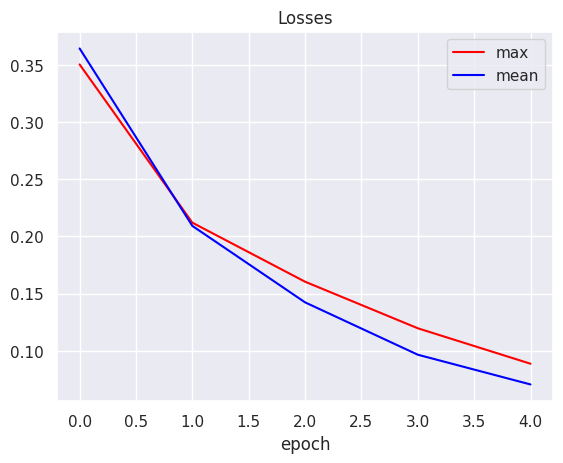

In [ ]:
for (name, values), color in zip(losses_type.items(), ['red', 'blue']):
    plt.plot(np.arange(len(losses_type[name])), losses_type[name], color=color, label=name)

plt.title('Losses')
plt.xlabel("epoch")
plt.legend()
plt.show()

Лучшая accuracy для подхода max: 91.22
Лучшая accuracy для подхода mean: 91.20


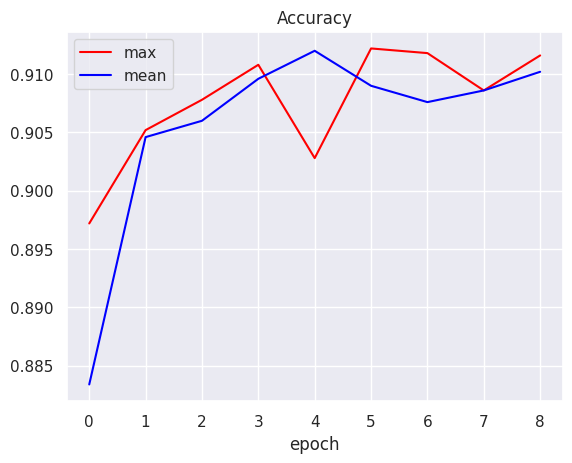

In [ ]:
for (name, values), color in zip(losses_type.items(), ['red', 'blue']):
    plt.plot(np.arange(len(acc_type[name][1:])), acc_type[name][1:], color=color, label=name)
    print(f"Лучшая accuracy для подхода {name}: {(max(acc_type[name]) * 100):.2f}")

plt.title('Accuracy')
plt.xlabel("epoch")
plt.legend()
plt.show()

In [ ]:
model7 = GRU(hidden_dim=256, vocab_size=len(vocab), aggregation_type='max').to(device)
model7.load_state_dict(torch.load('model_max_state_dict_epoch_4_91.22.pt'))

<ipython-input-32-977aad9ac8a5>:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model7.load_state_dict(torch.load('model_max_state_dict_epoch_4_91.22.pt'))


<All keys matched successfully>

In [ ]:
model7.eval()
print('Accuracy:',evaluate(model7)*100)

Accuracy: 91.21999740600586


### **Модифицированные GRU-модели и их метрики (все модели в состоянии eval() )**

In [ ]:
print(f'Accuracy of GRU + hidden_dim = 512 : {(evaluate(model5))*100:.2f}')
print(f'Accuracy of GRU + dropout(0.2): {evaluate(model6)*100:.2f}')
print(f'Accuracy of GRU + linear output/input //2 : {evaluate(model7)*100:.2f}')

Accuracy of GRU + hidden_dim = 512 : 92.02
Accuracy of GRU + dropout(0.2): 91.94
Accuracy of GRU + linear output/input //2 : 91.22


### **Итоговая лучшая метрика**

Получилось выбить на модели GRU - hidden_dim=512

In [ ]:
model5.eval()
print('Accuracy:',evaluate(model5)*100)

Accuracy: 92.0199990272522


# **Выводы по работе моделей**

*   Укажите, какие из экспериментов принесли улучшение, а какие --- нет.
*   Проанализируйте графики сходимости моделей в проведенных экспериментах. Являются ли колебания качества обученных моделей существенными в зависимости от эпохи обучения, или же сходимость стабильная?
*   Укажите, какая модель получилась оптимальной.





1.   По сранению с обычной моделью, которую мы использовали на семинаре (VanillaRNN), GRU & LSTM справлялись гораздо лучше с поставленной задачей.
При этом LSTM показывал более плохие результаты по сравнению с GRU, возможно, это может быть обусловлено сложностью самой модели.
Использование большего количества нейронов улучшило результаты модели и позволило получить метрику Accuracy, равную 92.01%, в то время как обычная GRU-модель показала результат около 91.92%. Изменение величины дропаута до 0.2 совсем немного повысило необходмую метрику, на 0.01%, уменьшение количества нейронов в линейных слоях ухудшило метрику.

2.   На VanillaRNN сходимость более стабильна, чем на  GRU/ LSTM. На последних двух моделях колебания существенны относительно эпохи обучения.
3.   Лучшая модель, на которой удалось вывести самый высокий скор - GRU-модель, в которой я увеличила количество нейронов в скрытом слое до 512. Это повысило время выполнения кода, но помогло увеличить метрику до 92.01 %







## **Посмотрим на работу лучшей модели**

In [ ]:
def show_predictions(model, dataloader, num_examples=5):
    model.eval()  # режим валидации

    batch = next(iter(dataloader))  # берем один батч
    input_ids = batch['input_ids'][:num_examples]  # берем num_examples
    true_labels = batch['label'][:num_examples]

    # пропускаем input_ids и делаем предсказания (обязательно отключаем градиент)
    with torch.no_grad():
        logits = model(input_ids)
        predicted_labels = logits.argmax(dim=1)  # предсказанные метки -тк у нас возвращается матрица с уверенностями (логитами), то мы беерм максимальный логит и присваеваем высказывание к классу N (индексу)

    for i in range(num_examples):
        token_ids = input_ids[i].cpu().numpy()
        # если нет в словаре, то меняем на unk
        text = " ".join([ind2word.get(idx, '<unk>') for idx in token_ids if idx not in {word2ind['<bos>'], word2ind['<eos>'], word2ind['<pad>']}])

        print(f"Текст: {text}")
        print(f"Истинный класс: {true_labels[i].item()}")
        print(f"Предсказанный класс: {predicted_labels[i].item()}")
        print("-" * 50)


show_predictions(model5, eval_dataloader, num_examples=5)


Текст: <unk> gets deeper into it <unk> <unk> the software maker adds a network management application it also updates its <unk> <unk> software
Истинный класс: 3
Предсказанный класс: 3
--------------------------------------------------
Текст: seven killed in kabul bloodshed at least seven people have been killed in a bomb blast in central kabul the second deadly explosion in afghanistan over the weekend
Истинный класс: 0
Предсказанный класс: 0
--------------------------------------------------
Текст: bluetooth group outlines strategy newsfactor newsfactor with bluetooth shortrange wireless technology finding its way into an array of hardware products ranging from mobile phones to <unk> <unk> systems a working group promoting the specification has outlined a strategy to make it even more attractive and useful
Истинный класс: 3
Предсказанный класс: 3
--------------------------------------------------
Текст: <unk> <unk> from woods the new king of golf is a lion vijay singh has a golf swing